# Data Aggregation and building a Recommender System
This part of the project describes developing a **Content-based Recommender System** based on **cosine similarity** between vectors containing **sums of various tags per cluster**. I've also created two interactive maps showing top cluster features to locate cluster you liked before and to get top five clusters based on that.

In [344]:
# Basic libraries
import pandas as pd
import geopandas as gpd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity # to find similarities between clusters

import folium # mapping

In [345]:
# Data Import
df = pd.read_csv('../data/POIs_clustered_4326.csv', index_col = 'Unnamed: 0', low_memory=False) # importing csv as DataFrame

df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) # coordinates formatting to feed into GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.set_crs('epsg:4326', inplace = True) # setting source projection

gdf.shape 

(5224, 296)

In [346]:
gdf.head(3)

,geometry,name,amenity,addr:street,drink:beer,drink:wine,drink:sake,drink:coffee,drink:tea,drink:espresso,...,pinsa,shawarma,garlic,waffle,napoletana,fried_cheese_sticks,modern,gyros,local,cluster
61670779,POINT (-122.43102 37.77214),Woods Lowside,pub,Haight Street,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,79
61671096,POINT (-122.43122 37.77191),Toronado,pub,Haight Street,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,79
61671382,POINT (-122.43176 37.77205),Molotov's,pub,Haight Street,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,248


_______
### Tags aggregation
I've decided just to sum tags by cluster. Because the number of points is important. One person will like a small area with a couple of vegetarian restaraunts, when another prefers busy area with dozens of chinese restaraunts, like famous San Francisco Chinatown.

In [349]:
# Aggregating places into clusters and summing all the tags together
tags_by_cluster = gdf.groupby(by = 'cluster').agg(sum)

# Looking at results
tags_by_cluster.sum().sort_values()

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_17247/1049853611.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tags_by_cluster = gdf.groupby(by = 'cluster').agg(sum)


Unnamed: 258                   0
belgian                        1
pub                            1
mongolian                      1
creole                         1
                            ... 
amenity_fast_food            356
amenity_place_of_worship     383
wheelchair                   621
amenity_cafe                 726
amenity_restaurant          1857
Length: 291, dtype: int64

In [350]:
# Dataframe
tags_by_cluster.head(3)

,drink:beer,drink:wine,drink:sake,drink:coffee,drink:tea,drink:espresso,drink:whisky,drink:hot_chocolate,cocktails,diet:vegetarian,...,omelette,pinsa,shawarma,garlic,waffle,napoletana,fried_cheese_sticks,modern,gyros,local
cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [352]:
# Dimensions
tags_by_cluster.shape

(300, 291)

### Recommender System
To calculate similarities between clusters I used cosine similarity which is widely used in content-based recommender systems like this one (another option is user-based system). It's called cosine because it's calculated as a cosine of an angle between two vectors.

In [38]:
# Calculate the cosine similarity matrix between clusters
cosine_similarity = cosine_similarity(tags_by_cluster)

# Create a dataframe with the cosine similarity scores
similarity_df = pd.DataFrame(cosine_similarity, index=tags_by_cluster.index, columns=tags_by_cluster.index)

In [39]:
similarity_df

cluster,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.774967,0.784389,0.280393,0.523062,0.766812,0.698880,0.631173,0.632886,0.769744,...,0.403227,0.454882,0.792524,0.854212,0.696082,0.756070,0.376978,0.785578,0.839798,0.478702
1,0.774967,1.000000,0.772281,0.370239,0.429391,0.738119,0.783945,0.606272,0.635979,0.792721,...,0.515225,0.641199,0.854136,0.788163,0.701571,0.864991,0.188896,0.822154,0.737292,0.696030
2,0.784389,0.772281,1.000000,0.419801,0.391293,0.815055,0.754418,0.815163,0.562926,0.859661,...,0.644426,0.565346,0.768622,0.800277,0.713828,0.771389,0.075309,0.834013,0.850894,0.630257
3,0.280393,0.370239,0.419801,1.000000,0.239112,0.377010,0.350091,0.396522,0.481987,0.355047,...,0.542335,0.295141,0.295395,0.214994,0.224897,0.355641,0.000000,0.333598,0.304232,0.517991
4,0.523062,0.429391,0.391293,0.239112,1.000000,0.329078,0.350548,0.256285,0.492366,0.299911,...,0.411729,0.335030,0.361669,0.339046,0.270765,0.376274,0.615882,0.433224,0.287546,0.337100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.756070,0.864991,0.771389,0.355641,0.376274,0.689938,0.814806,0.580948,0.647514,0.797053,...,0.537779,0.608581,0.774287,0.721171,0.680150,1.000000,0.183794,0.807679,0.715269,0.683198
296,0.376978,0.188896,0.075309,0.000000,0.615882,0.000000,0.000000,0.000000,0.444029,0.000000,...,0.000000,0.000000,0.167059,0.067359,0.000000,0.183794,1.000000,0.083380,0.000000,0.000000
297,0.785578,0.822154,0.834013,0.333598,0.433224,0.777346,0.868823,0.664540,0.654675,0.856297,...,0.642878,0.598715,0.813287,0.807856,0.766129,0.807679,0.083380,1.000000,0.795260,0.667676


In [390]:
# Saving similarities to csv
similarity_df.to_csv('../data/similarity.csv')

To visualise how sectors are similar to each other, I've created a heatmap.

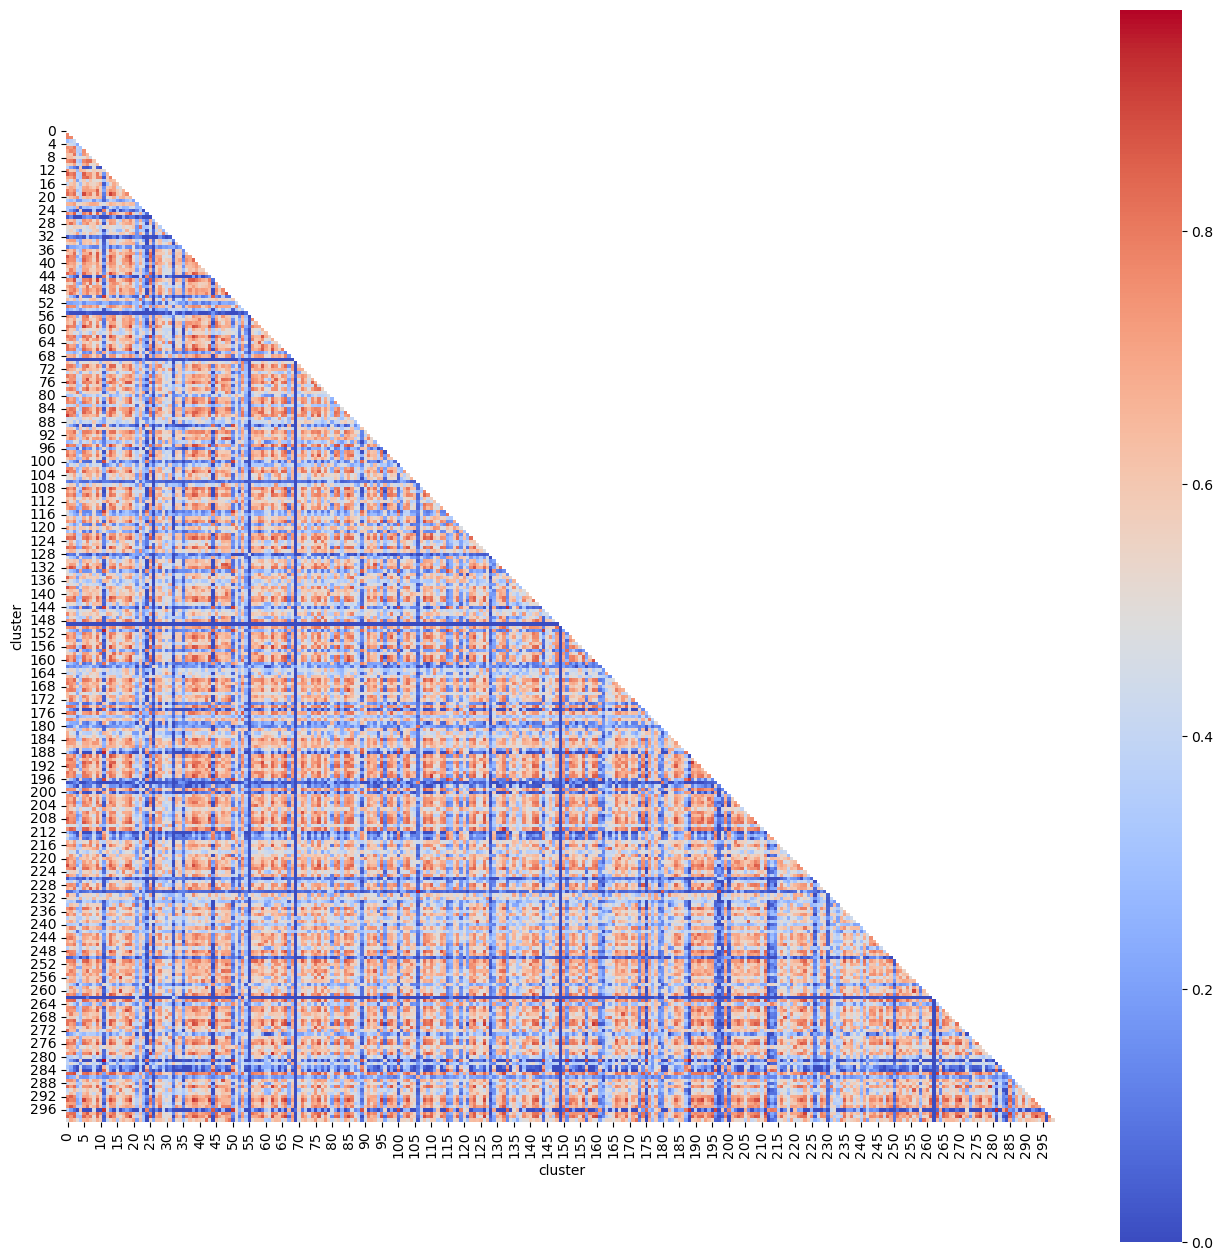

In [356]:
# Plotting a heatmap
plt.figure(figsize = (16, 16))

# Masking upper part 
mask = np.zeros_like(similarity_df)
mask[np.triu_indices_from(mask)] = True

# Similarity heatmap
sns.heatmap(similarity_df,
           mask = mask,
            cmap = 'coolwarm',
           square = True); 

__________
### Populating clusters with attributes
When recommended clusters are displayed on a map, they better be informative, saying what are the top tags in the given cluster. So in this section I'm creating pretty cluster names with major streets and top tags so user gets an idea what they can possibly like about this new place.

In [358]:
# Getting most popular streets within cluster's points of interests
clusters = pd.read_csv('../data/cluster_centers.csv', index_col = 'Unnamed: 0') # import of dataset with cluster centroids

names = gdf.groupby(['cluster'])['addr:street'].agg(lambda x: pd.Series.mode(x)[:2]).to_frame() # to name clusters, extracting two most frequent street names

clusters = pd.concat([clusters, names], axis = 1)
clusters

,0,1,addr:street
0,-1.362422e+07,4.549158e+06,"[Beale Street, Brannan Street]"
1,-1.363289e+07,4.545950e+06,9th Avenue
2,-1.362837e+07,4.545768e+06,18th Street
3,-1.362920e+07,4.549085e+06,Fillmore Street
4,-1.362950e+07,4.540478e+06,Ocean Avenue
...,...,...,...
295,-1.362786e+07,4.547758e+06,Franklin Street
296,-1.362534e+07,4.549477e+06,2nd Street
297,-1.362440e+07,4.546821e+06,Warriors Way
298,-1.363301e+07,4.546258e+06,Irving Street


In [359]:
# Most popular Streets
clusters['addr:street'].value_counts()

Mission Street                     13
Market Street                      10
Geary Boulevard                    10
3rd Street                          8
Irving Street                       6
                                   ..
Monterey Boulevard                  1
[Fillmore Street, Union Street]     1
[26th Street, Marin Street]         1
[Davis Street, Front Street]        1
Franklin Street                     1
Name: addr:street, Length: 169, dtype: int64

________
### Points to Polygons
To display clusters on a map, I'm converting them to polygons with convex_hull method from GeoPandas.

In [361]:
# Applying geopandas convex_hull
res = gdf.dissolve('cluster').convex_hull
res.to_wkt()

cluster
0      POLYGON ((-122.387991 37.7830632, -122.3891406...
1      POLYGON ((-122.4691241 37.7603184, -122.466434...
2      POLYGON ((-122.4261309 37.7582605, -122.428648...
3      POLYGON ((-122.4329092 37.7834918, -122.434583...
4      POLYGON ((-122.4354016 37.7227363, -122.437729...
                             ...                        
295    POLYGON ((-122.42106793338169 37.7739097534125...
296    POLYGON ((-122.3977478 37.7865514, -122.398547...
297    POLYGON ((-122.3907088 37.7671909, -122.391587...
298    POLYGON ((-122.46898717963754 37.7636883234471...
299    POLYGON ((-122.43542299999999 37.76296285, -12...
Length: 300, dtype: object

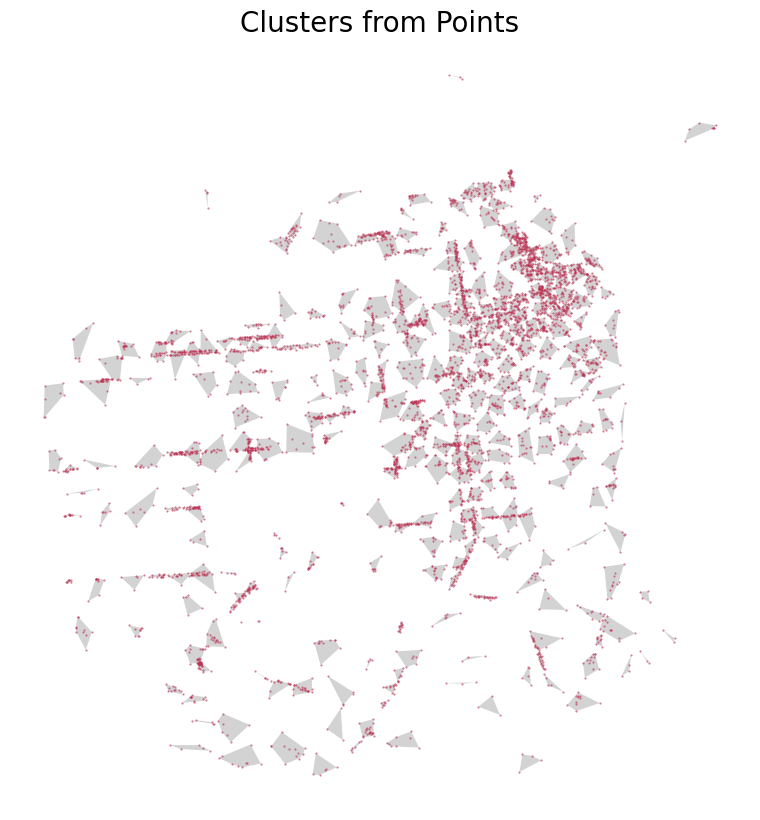

In [362]:
# Plotting points and polygons together
ax = res.plot(color = 'lightgrey', figsize = (10,10))
gdf.plot(ax=ax, marker='.', color='#BE3455', markersize=1, alpha = 0.7)

plt.title('Clusters from Points', size = 20)

ax.set_axis_off()

plt.savefig('../output/clusters_from_points.png', dpi = 900, bbox_inches = 'tight');

_________________
### Creating output cluster layer
Some final touches to perform. Merging geometry and attributes together, generating top tag and top 5 tags categories, cleaning columns that are to be displayed on a map.

In [363]:
# Getting top five tags for every cluster
top_tags = []
for i in range (0, 300):
    tags = tags_by_cluster.loc[i,:].sort_values(ascending = False)[:5]
    top_tags.append(tags.index)

In [364]:
# Putting it all together into one GeoDataFrame with cluster polygons
gdf_clusters = gpd.GeoDataFrame(clusters, geometry=res)
gdf_clusters['top_tags'] = top_tags

In [365]:
# Creating a function to make top_tags column more readable
def clean_tags(text):
    '''
    Function specifically to clean top tags columns
    '''
    text = str(text)
    text = text.replace("],\n      dtype='object')", "")
    text = text.replace("Index(['", "")
    text = text.replace("\n", "")
    text = text.replace("       ", " ")
    text = text.replace("amenity_", "")
    text = text.replace("'","")
    text = text.replace("_"," ")
    return(text)

# Applying function to top tags column
gdf_clusters['top_tags'] = gdf_clusters['top_tags'].map(lambda x: clean_tags(x))

In [366]:
# Creating cluster name column
gdf_clusters['name'] = gdf_clusters.index.map(lambda x: 'Cluster # ' + str(x) + ': ')
gdf_clusters['name'] = gdf_clusters['name'] + gdf_clusters['addr:street'].astype(str)

In [367]:
# Getting cluster centroids in lat lon
gdf_clusters['centroids'] = gdf_clusters.centroid

gdf_clusters['lon'] = gdf_clusters.centroids.x
gdf_clusters['lat'] = gdf_clusters.centroids.y

gdf_clusters = gdf_clusters[['geometry', 'top_tags', 'name', 'centroids', 'lon', 'lat']]

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_17247/2494406606.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_clusters['centroids'] = gdf_clusters.centroid


In [368]:
# Creating top category column
gdf_clusters['top_category'] = gdf_clusters['top_tags'].map(lambda x: x.split(',')[0])
gdf_clusters.top_category.value_counts()

restaurant                            169
place of worship                       29
cafe                                   26
wheelchair                             17
religion christian                     12
vending machine                         6
bar                                     5
fast food                               5
diet:vegetarian                         5
clock                                   2
post office                             2
fountain                                2
outdoor seating                         2
fuel                                    2
library                                 2
denomination seventh day adventist      1
studio                                  1
fire station                            1
binoculars                              1
denomination catholic                   1
seafood                                 1
theatre                                 1
public bookcase                         1
bank                              

In [369]:
# Saving result
gdf_clusters.to_csv('../data/cluster_attributes.csv')

__________
### Checking recommender system
Let's say I really liked cluster #5 before and I want to see which other parts of the city I might like.

In [371]:
# Top 5 similar clusters to #5
similarity_df[5].sort_values(ascending=False)[1:6]

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_17247/3274344321.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  similarity_df[5].sort_values(ascending=False)[1:6]


cluster
59     0.907652
293    0.906481
156    0.906178
19     0.899130
209    0.870354
Name: 5, dtype: float64

In [372]:
similarity_df.head(2)

cluster,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
cluster,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.774967,0.784389,0.280393,0.523062,0.766812,0.698880,0.631173,0.632886,0.769744,...,0.403227,0.454882,0.792524,0.854212,0.696082,0.756070,0.376978,0.785578,0.839798,0.478702
1,0.774967,1.000000,0.772281,0.370239,0.429391,0.738119,0.783945,0.606272,0.635979,0.792721,...,0.515225,0.641199,0.854136,0.788163,0.701571,0.864991,0.188896,0.822154,0.737292,0.696030


In [373]:
gdf_clusters.head(3)

,geometry,top_tags,name,centroids,lon,lat,top_category
0,"POLYGON ((-122.38799 37.78306, -122.38914 37.7...","wheelchair, restaurant, bicycle rental, americ...",Cluster # 0: ['Beale Street' 'Brannan Street'],POINT (-122.38859 37.78518),-122.388588,37.785176,wheelchair
1,"POLYGON ((-122.46912 37.76032, -122.46643 37.7...","restaurant, cafe, indian, coffee shop, chinese",Cluster # 1: 9th Avenue,POINT (-122.46705 37.76206),-122.467052,37.762061,restaurant
2,"POLYGON ((-122.42613 37.75826, -122.42865 37.7...","restaurant, cafe, religion christian, place of...",Cluster # 2: 18th Street,POINT (-122.42606 37.76081),-122.426062,37.760809,restaurant


In [374]:
def get_recommendations(cluster):
    '''
    Creating a function that takes cluster number and displays 5 most similar ones.
    '''
    indexes = similarity_df[cluster].sort_values(ascending = False)[1:6].index
    gdf_mini = gdf_clusters.iloc[indexes]
    return(gdf_mini[['name', 'top_tags']])

In [375]:
get_recommendations(3)

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_17247/2779821401.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  indexes = similarity_df[cluster].sort_values(ascending = False)[1:6].index


,name,top_tags
79,Cluster # 79: Haight Street,"restaurant, fast food, diet:vegetarian, diet:v..."
20,Cluster # 20: ['Green Street' 'Stockton Street'],"restaurant, cafe, bank, italian, outdoor seating"
274,Cluster # 274: [],"place of worship, religion christian, religion..."
31,Cluster # 31: King Street,"restaurant, fast food, bar, cafe, wheelchair"
83,Cluster # 83: Post Street,"restaurant, japanese, indoor seating, ramen, p..."


____________
### Maps
First map allows user to navigate to clusters they liked before and get the cluster's number. Second map shows only five top recommendations based on the given cluster number. Let's see how it works.

In [376]:
m = folium.Map(location=[37.7775, -122.416389], 
               zoom_start=13,
               min_zoom=12,
               tiles='openstreetmap',
               max_bounds=True)

for _, row in gdf_clusters.iterrows():

    polys = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001) # otherwise polygons won't display
    geojson = polys.to_json()
    geojson = folium.GeoJson(data=geojson,
                           style_function=lambda x: {'fillColor': 'purple', 'fillOpacity': 0.2, 'weight': 0.5})
    
    folium.Popup(row['name'] + ' ________ top tags: \n ' + row['top_tags']).add_to(geojson)
    geojson.add_to(m)

m.save('../output/clusters.html') # saving map    
m # display

Based on the map above, I've found one of my favorite areas - Mission Rock, cluster #107. Let's see what else areas I might like. 

In [389]:
# Getting recommendations based on cluster 107
indexes = similarity_df[107].sort_values(ascending = False)[1:6].index
gdf_mini = gdf_clusters.iloc[indexes]
gdf_mini[['name', 'top_tags']]

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_17247/3631653999.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  indexes = similarity_df[107].sort_values(ascending = False)[1:6].index


,name,top_tags
47,Cluster # 47: Geary Street,"restaurant, fast food, cafe, thai, bar"
90,Cluster # 90: Chestnut Street,"restaurant, outdoor seating, bank, cafe, wheel..."
147,Cluster # 147: Columbus Avenue,"restaurant, italian, wheelchair, outdoor seati..."
256,Cluster # 256: Pier 39,"telephone, restaurant, fast food, ice cream, f..."
63,Cluster # 63: Mission Street,"restaurant, wheelchair, cafe, bar, outdoor sea..."


In [388]:
# Displaying 5 recommended clusters only
m2 = folium.Map(location=[37.7775, -122.416389], 
               zoom_start=13,
               min_zoom=12,
               tiles='openstreetmap',
               max_bounds=True)

for _, row in gdf_mini.iterrows():

    polys = gpd.GeoSeries(row['geometry']).simplify(tolerance=0.001) # otherwise polygons won't display
    geojson = polys.to_json()
    geojson = folium.GeoJson(data=geojson,
                           style_function=lambda x: {'fillColor': 'purple', 'fillOpacity': 0.5, 'weight': 1})
    
    folium.Popup(row['name'] + ' ________ top tags: \n ' + row['top_tags']).add_to(geojson)
    geojson.add_to(m2)

m2.save('../output/recommended_clusters.html') # saving map    
m2 # display

I'll make sure to check those out! At least because of the vegetarian options!